# MPS using the deesse wrapper - inequality conditioning data


## Main points addressed:
- how to set inequality conditioning data

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import from package 'geone'
from geone import img
import geone.imgplot as imgplt
import geone.customcolors as ccol
import geone.deesseinterface as dsi

## Conditioning by inequalities

In addition to usual conditioning data (hard data), deesse handles conditioning data by inequalities. 

Inequality conditioning data can be given for a simulated variable by appending the suffix `_min` (resp. `_max`) to the variable name: the given values are then minimal (resp. maximal) bounds, i.e. indicating that, for this variable, the simulated values should be greater than or equal to (resp. less than or equal to) the given values.

Hence, one location in the simulation grid can be conditioned by a minimal value, a maximal value, or both minimal and maximal values.

Inequality conditioning data is generally used for continuous variables. However, such data is also handled for categorical variables: in this case, one can only indicate that the simulated category (discrete value) is within a contiguous range of categories. 

### Limitations
- Inequality data cannot be used for a variable simulated using the *relative distance* mode (see example in the jupyter notebook `ex_deesse_04_continuous_sim`). If deesse is launched with such specifications, the simulation will be *stopped* and an error retrieved.
- Inequality data cannot be used for a variable for which *connectivity data* is specified (see example in the jupyter notebook `ex_deesse_07_connectivity_data`). If deesse is launched with such specifications, the simulation will be done but the inequality data will be ignored (and a warning will be displayed).

## Basic example below

### Training image (TI)
Read the TI and plot it. (Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006, doi: 10.1007/s11004-005-9004-x*)

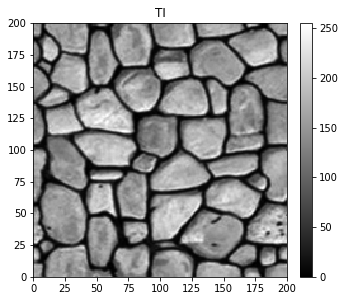

In [2]:
ti = img.readImageGslib('tiContinuous.gslib')

plt.figure(figsize=(5,5))
imgplt.drawImage2D(ti, cmap=ccol.cmapB2W, title='TI')

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [3]:
nx, ny, nz = 200, 200, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Conditioning data
Define some conditioning data in a point set. Consider that the name of the simulated variable is 'code'. Here 4 conditioning locations are considered with a usual hard data value at the location of index 0 (variable: 'code'), a minimal value only (inequality data, variable: 'code_min') at the location of index 1, a maximal value only (inequality data, variable: 'code_max') at the location of index 2, and a minimal value and a maximal value (inequality data, variables: 'code_min' and 'code_max') at the location of index 3.

In [4]:
npt = 4  # number of points
nv = 6   # number of variables including x, y, z coordinates
varname = ['x', 'y', 'z', 'code', 'code_min', 'code_max'] # list of variable names
v = np.array([
    [ 65.5,  65.5, 0.5,     120, np.nan, np.nan], # loc. #0: x, y, z, code, code_min (undef.), code_max (undef.)
    [135.5,  65.5, 0.5,  np.nan,    175, np.nan], # loc. #1: x, y, z, code (undef.), code_min, code_max (undef.)
    [ 65.5, 135.5, 0.5,  np.nan, np.nan,     40], # loc. #2: x, y, z, code (undef.), code_min (undef.), code_max
    [135.5, 135.5, 0.5,  np.nan,     60,    160]  # loc. #3: x, y, z, code (undef.), code_min, code_max
    ]).T # variable values: (nv, npt)-array
cd = img.PointSet(npt=npt, nv=nv, varname=varname, val=v)

### Fill the input structure for deesse and launch deesse
**Note:** the variable name in `deesse_input` class is varname=`'code'`, the variable name in `cd.varname` is: `'code'` for usual hard data, `'code_min'` for minimal value and `'code_max'` for maximal value.

In [5]:
nreal = 20
deesse_input = dsi.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',     # consistent name for the simulated variable
    nTI=1, TI=ti,
    dataPointSet=cd,          # ... and the names used in the data point set
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.02,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = dsi.deesseRun(deesse_input)

Deesse running... [VERSION 3.2 / BUILD NUMBER 20200501 / OpenMP 7 thread(s)]
Deesse run complete


### Retrieve the results
And store all the realizations in a single image (one variable per realization).

In [6]:
# Retrieve the realizations
sim = deesse_output['sim']

# Gather the nreal realizations into one image
all_sim = img.gatherImages(sim) # all_sim is one image with nreal variables

### Do some statistics on the simulated values at conditioning locations

In [7]:
# Get conditioning values ...
cd_value     = cd.val[3]     # for usual conditioning values   (variable index 3 in point set 'cd')
cd_value_min = cd.val[4]     # for minimal conditioning values (variable index 4 in point set 'cd')
cd_value_max = cd.val[5]     # for maximal conditioning values (variable index 5 in point set 'cd')

# Get index of conditioning location in simulation grid...
cd_grid_index = [img.pointToGridIndex(x, y, z, 
                                      all_sim.nx, all_sim.ny, all_sim.nz, 
                                      all_sim.sx, all_sim.sy, all_sim.sz, 
                                      all_sim.ox, all_sim.oy, all_sim.oz) 
                 for (x,y,z) in zip(cd.x(), cd.y(), cd.z())]
# .. and index of simulation grid cell along each direction
cd_ix = [ind[0] for ind in cd_grid_index]
cd_iy = [ind[1] for ind in cd_grid_index]
cd_iz = [ind[2] for ind in cd_grid_index]

# Get simulated values at conditioning locations
sim_value_at_cd_loc = [all_sim.val[:, cd_iz[j], cd_iy[j], cd_ix[j]] for j in range(cd.npt)]
# sim_value_at_cd_loc: list of 4(=cd.npt) np.array of length 20(=nreal)

### Do some statistics on the realizations (whole map, pixel-wise mean and standard deviation)

In [8]:
# Do statistics over all the realizations: compute the pixel-wise mean and standard deviation
sim_mean = img.imageContStat(all_sim, 'mean') # do statistics (pixel-wise mean)
sim_std = img.imageContStat(all_sim, 'std')   # do statistics (pixel-wise standard deviation)

### Display results
Plot in a figure: the TI, the mean and standard deviation of the realizations, two of them, and the box-plots of the simulated value at the conditioning locations.

Text(0.5, 1.0, 'Simulated values at cond. locations')

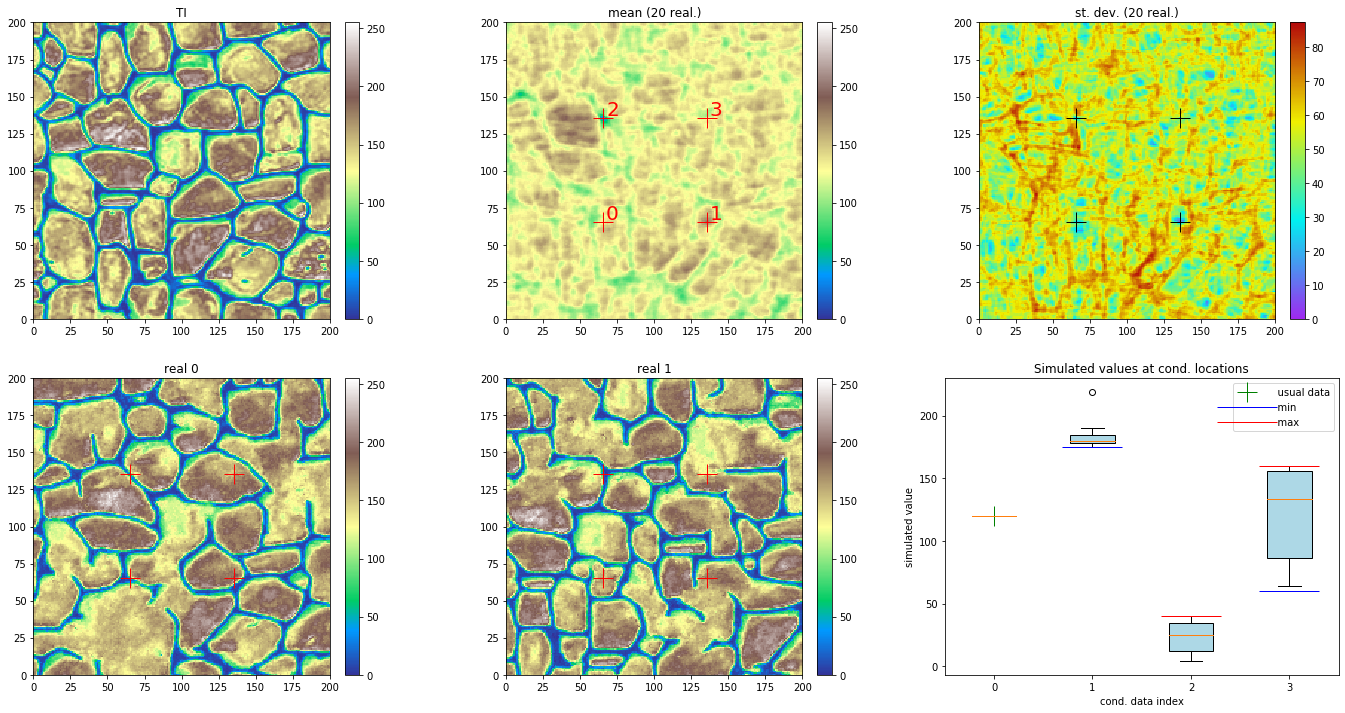

In [9]:
# Display

cmap = 'terrain' # color map for TI, realizations, and mean of the realizations

# figure ...
fig, ax = plt.subplots(2, 3, figsize=(24, 12))

# plot TI
plt.sca(ax[0, 0])
imgplt.drawImage2D(ti, cmap=cmap, vmin=ti.vmin(), vmax=ti.vmax(), title='TI')

# plot mean of realizations
plt.sca(ax[0, 1])
imgplt.drawImage2D(sim_mean, cmap=cmap, vmin=ti.vmin(), vmax=ti.vmax(), title='mean ({} real.)'.format(nreal))
plt.plot(cd.x(), cd.y(), '+', markersize=20, c='red') # add conditioning data points
for j in range(cd.npt):
    plt.text(cd.x()[j]+2, cd.y()[j]+2, '{}'.format(j), size=20, color='red') # add conditioning data point index

# plot standard deviation of realizations
plt.sca(ax[0, 2])
imgplt.drawImage2D(sim_std, title='st. dev. ({} real.)'.format(nreal))
plt.plot(cd.x(), cd.y(), '+', markersize=20, c='black') # add conditioning data points

# plot two realizations
for i in [0, 1]:
    # plot real #i
    plt.sca(ax[1, i])
    imgplt.drawImage2D(all_sim, iv=i, cmap=cmap, vmin=ti.vmin(), vmax=ti.vmax(), title='real {}'.format(i))
    plt.plot(cd.x(), cd.y(), '+', markersize=20, c='red') # add conditioning data points


# box-plot of simulated value at conditioning location
plt.sca(ax[1, 2])
bplot = plt.boxplot(sim_value_at_cd_loc, labels=np.arange(cd.npt), patch_artist=True)
for p in bplot['boxes']:
    p.set_facecolor('lightblue') # fill box plot with color

plt.plot(1+np.arange(cd.npt), cd_value,     lw=3, marker='+', ms=20, ls='none', c='green', label='    usual data')
plt.plot(1+np.arange(cd.npt), cd_value_min, lw=3, marker='_', ms=60, ls='none', c='blue' , label='    min')
plt.plot(1+np.arange(cd.npt), cd_value_max, lw=3, marker='_', ms=60, ls='none', c='red'  , label='    max')
plt.legend()
plt.xlabel('cond. data index')
plt.ylabel('simulated value')
plt.title('Simulated values at cond. locations')